In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn import model_selection
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [109]:
# global variables

INPUT_SHAPE_X = 128
INPUT_SHAPE_Y = 64
ITERATION = '6'
EPOCHS = 1000
BATCH_SIZE = 8

max_images = 2800 #2054 # max images per class

In [38]:
# load labels
csv_path = 'labels_preprocessed.csv'
labels = pd.read_csv(csv_path)
# replace NaN values with 0s
labels.fillna(0, inplace=True)

In [72]:
# load the images
eyes_path = 'eyes'
eyes_dir = os.listdir(eyes_path)
x_eyes = []
y_eyes = []
i = 0
class_0 = 0
class_1 = 0
class_2 = 0

# iterate over images
for image in eyes_dir:
    # load the image
    image_path = os.path.join(eyes_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    # preprocess the image
    if (img is not None):
    
        # check image class
        image_class = labels.loc[labels['imageid'] == image, 'orbital_tightening']

        if not image_class.empty:
            image_class = image_class.iloc[0]    
            
            # append an equal number of images from each class
            if (image_class == 0.0 and class_0 < max_images):
                x_eyes.append(img)
                y_eyes.append(image_class)
                class_0 += 1
                if (i == max_images*3):
                    break
                i+=1
                
                
            elif (image_class == 1.0 and class_1 < max_images-200):
                x_eyes.append(img)
                y_eyes.append(image_class)
                class_1 += 1
                if (i == max_images*3):
                    break
                i+=1
                
                
            elif (image_class == 2.0 and class_2 < max_images):
                x_eyes.append(img)
                y_eyes.append(image_class)
                class_2 += 1
                if (i == max_images*3):
                    break
                i+=1
  


In [73]:
# add flipped images from class 2
flipped_path = 'eyes-flipped'
for image in os.listdir(flipped_path):
    image_path = os.path.join(flipped_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    x_eyes.append(img)
    y_eyes.append(2)
    class_2 += 1

In [74]:
# add augmented images from class 2
aug_path = 'eyes-augmented'
for image in os.listdir(aug_path):
    image_path = os.path.join(aug_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    x_eyes.append(img)
    y_eyes.append(2)
    class_2 += 1

In [75]:
print(class_0, class_1, class_2)

2800 2600 2040


In [76]:
# preprocess
x_eyes = tf.keras.applications.vgg16.preprocess_input(np.array(x_eyes))

# split the dataset into train and test sets
x_train_val, x_test, y_train_val, y_test = model_selection.train_test_split(
    x_eyes, y_eyes, test_size=0.2, random_state=42)

# split the train and validation sets
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    x_train_val, y_train_val, test_size=0.2, random_state=42)

# one-hot code labels
y_train = tf.one_hot(y_train,3)
y_val = tf.one_hot(y_val,3)
y_test = tf.one_hot(y_test,3)

In [92]:
# create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.applications.vgg16.VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                                            include_top=False,
                                            input_shape=(INPUT_SHAPE_X, INPUT_SHAPE_Y, 3)))
model.add(tf.keras.layers.Flatten(input_shape=model.output_shape[1:]))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [110]:
# compile the model
earlystop = EarlyStopping(monitor='val_loss', patience=10)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [94]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 2, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 4096)              0         
                                                                 
 dense_18 (Dense)            (None, 256)               1048832   
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               65792     
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 128)              

In [111]:
# train the model
hist = model.fit(x_train, y_train, 
              epochs=EPOCHS,
              batch_size=BATCH_SIZE, 
              validation_data=(x_val, y_val),
              callbacks=[earlystop])

Epoch 1/1000
596/596 [==============================] - 10s 12ms/step - loss: 0.2728 - accuracy: 0.8925 - val_loss: 0.9844 - val_accuracy: 0.6910
Epoch 2/1000
596/596 [==============================] - 7s 12ms/step - loss: 0.2138 - accuracy: 0.9200 - val_loss: 1.3919 - val_accuracy: 0.6448
Epoch 3/1000
596/596 [==============================] - 7s 11ms/step - loss: 0.1982 - accuracy: 0.9330 - val_loss: 1.0088 - val_accuracy: 0.7019
Epoch 4/1000
596/596 [==============================] - 7s 11ms/step - loss: 0.1381 - accuracy: 0.9532 - val_loss: 1.1158 - val_accuracy: 0.6877
Epoch 5/1000
596/596 [==============================] - 8s 13ms/step - loss: 0.0964 - accuracy: 0.9670 - val_loss: 1.5440 - val_accuracy: 0.6465
Epoch 6/1000
596/596 [==============================] - 7s 12ms/step - loss: 0.1134 - accuracy: 0.9620 - val_loss: 1.1721 - val_accuracy: 0.6868
Epoch 7/1000
596/596 [==============================] - 7s 12ms/step - loss: 0.0723 - accuracy: 0.9767 - val_loss: 1.2666 - val_a

In [116]:
# save the model and training history
path = 'model_' + ITERATION
model.save(path)

history_df = pd.DataFrame(hist.history)
path = 'eyes_history_' + ITERATION +'.csv'
history_df.to_csv(path, index=False)

In [112]:
# evaluate the model
results = model.evaluate(x_test, y_test)
print(results)

47/47 [==============================] - 0s 7ms/step - loss: 1.3995 - accuracy: 0.7003
[1.3994545936584473, 0.7002688050270081]


In [113]:
# make predictions
prob_array = model.predict(x_test)
class_indices = np.argmax(prob_array, axis=1)

# convert the class indices to a one-hot encoded array
class_indices = np.argmax(prob_array, axis=1)
num_classes = 3
y_pred = np.zeros((prob_array.shape[0], num_classes))
y_pred[np.arange(prob_array.shape[0]), class_indices] = 1

47/47 [==============================] - 0s 6ms/step


In [114]:
# make a classification report

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Score 0', 'Score 1', 'Score 2']))


Accuracy: 0.70


Classification Report

              precision    recall  f1-score   support

     Score 0       0.70      0.71      0.71       589
     Score 1       0.61      0.56      0.58       508
     Score 2       0.80      0.86      0.83       391

   micro avg       0.70      0.70      0.70      1488
   macro avg       0.70      0.71      0.71      1488
weighted avg       0.70      0.70      0.70      1488
 samples avg       0.70      0.70      0.70      1488



Confusion Matrix

[[421 146  22]
 [164 284  60]
 [ 18  36 337]]


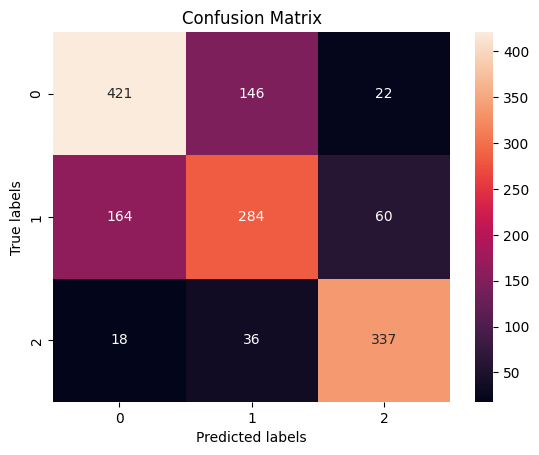

In [115]:
# make a confusion matrix
confusion = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
print('Confusion Matrix\n')
print(confusion)

lables = ['0','1','2']    
ax= plt.subplot()
sns.heatmap(confusion, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(lables); ax.yaxis.set_ticklabels(lables);
plt.show()

In [117]:
!zip model_6.zip model_6

  adding: model_6/ (stored 0%)
